数据集大小 100000
用户数: 943, 电影数: 1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


 30%|███       | 11368/37500 [00:12<00:24, 1083.05it/s, Epoch=9, Train RMSE=1.2082, Test RMSE=1.2464]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 40%|███▉      | 14887/37500 [00:15<00:23, 957.58it/s, Epoch=11, Train RMSE=1.1331, Test RMSE=1.1869] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 18482/37500 [00:19<00:17, 1087.64it/s, Epoch=14, Train RMSE=1.0786, Test RMSE=1.1243]IOPub message rate exceeded.
The Jupyter server will tempor

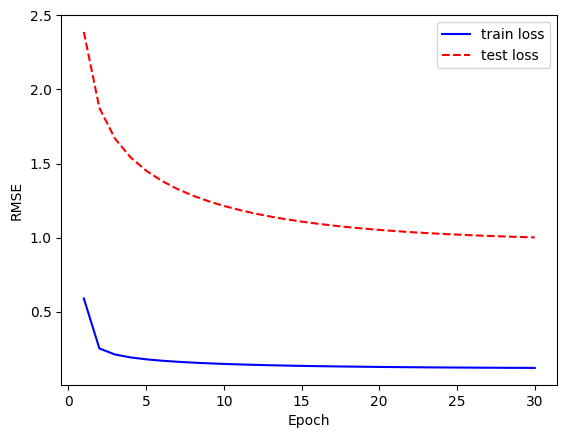

[2.57712395 3.48622005 3.76150216 3.58604004 4.8058418  3.47284112
 3.37246031 4.0917956  3.02605747 3.45742155]
[2 4 4 4 5 2 3 1 4 4]


In [1]:
# 矩阵分解

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

data = np.loadtxt('movielens_100k.csv', delimiter=',', dtype=int)
print('数据集大小', len(data))
# 用户和电影都是从0开始编号的， 我们将其转化为从0开始
data[:, :2] = data[:, :2] -1

# 计算用户和电影数量
users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)
print(f'用户数: {user_num}, 电影数: {item_num}')


# 划分训练集和测试集
np.random.seed(0)

ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train, test = data[:split], data[split:]

# 统计训练集中每个用户和电影出现的数量，作为正则化的权重
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

# 用户和电影的编号要作为下标，必须保存为整数
user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]



class MF:
    def __init__(self, N, M, d):
        # N是用户数量，M是电影数量，d是特征维度
        # 定义模型参数
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))
    def pred(self, user_id, item_id):
        # 预测用户user_id 对电影item_id的评分
        # 获得用户偏好和电影特征
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        rating_pred = np.sum(user_param * item_param, axis=1)
        return rating_pred
    def update(self, user_grad, item_grad, lr):
        # 根据参数的特度更新参数
        self.user_params -= lr * user_grad
        self.item_params -= lr * item_grad

def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # 随机梯度下降
            train_rmse = 0
            for i in range(batch_num):
                # 获取当前批量
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # 计算模型预测
                y_pred = model.pred(user_batch, item_batch)
                # 计算梯度
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                model.update(P_grad / len(user_batch), Q_grad / len(user_batch), learning_rate)

                train_rmse += np.mean(errs ** 2)
                # 更新进度条
                pbar.set_postfix({
                    'Epoch': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)

            # 计算测试集上的RMSE
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)

    return train_losses, test_losses

# 超参数
feature_num = 16 # 特征数
learning_rate = 0.1 # 学习率
lbd = 1e-4 # 正则化强度
max_training_step = 30
batch_size = 64 # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd, max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) # 把张量转换为numpy数组
print(y_test[:10])
